In [25]:
pip install marimo


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /Users/eshashah/opt/anaconda3/bin/python -m pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 105, in _run_wrapper
    status = _inner_run()
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 96, in _inner_run
    return self.run(options, args)
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/req_command.py", line 68, in wrapper
    return func(self, options, args)
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/commands/install.py", line 486, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/metadata/pkg_resources.py", line 192, in versi

In [26]:
pip install polars duckdb sqlglot


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /Users/eshashah/opt/anaconda3/bin/python -m pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 105, in _run_wrapper
    status = _inner_run()
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 96, in _inner_run
    return self.run(options, args)
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/req_command.py", line 68, in wrapper
    return func(self, options, args)
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/commands/install.py", line 486, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "/Users/eshashah/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/metadata/pkg_resources.py", line 192, in versi

In [27]:
import marimo as mo

# NFL Metric Development

The goal of this notebook is to develop a metric that calculates the separation being created due to the wide receiver after the ball is thrown.

1. Calculate the raw separation gain (RSG)
2. Calculate the WR-Only Separation (WOS), using a XGBoost regression model.

Each part will be properly defined below.

## Installing Required Libraries & View Data

In [28]:
import pandas as pd
import numpy as np
import plotly.express as px
import altair as alt
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import matplotlib.pyplot as plt
import polars as pl

In [29]:
##Define the files
input_all = "data/input_all.parquet"
output_all = "data/output_all.parquet"
supplementary_data = "data/supplementary_data.parquet"

In [30]:
input_df = mo.sql(
    f"""
    SELECT * FROM '{input_all}'
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [31]:
input_df.head()

game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""2023090700""","""101""","""False""","""54527""","""1""","""right""","""42""","""Bryan Cook""","""6-1""","""210""","""1999-09-07""","""FS""","""Defense""","""Defensive Coverage""","""52.33""","""36.94""","""0.09""","""0.39""","""322.4""","""238.24""","""21""","""63.2599983215332""","""-0.219999998807907"""
"""2023090700""","""101""","""False""","""54527""","""2""","""right""","""42""","""Bryan Cook""","""6-1""","""210""","""1999-09-07""","""FS""","""Defense""","""Defensive Coverage""","""52.33""","""36.94""","""0.04""","""0.61""","""200.89""","""236.05""","""21""","""63.2599983215332""","""-0.219999998807907"""
"""2023090700""","""101""","""False""","""54527""","""3""","""right""","""42""","""Bryan Cook""","""6-1""","""210""","""1999-09-07""","""FS""","""Defense""","""Defensive Coverage""","""52.33""","""36.93""","""0.12""","""0.73""","""147.55""","""240.6""","""21""","""63.2599983215332""","""-0.219999998807907"""
"""2023090700""","""101""","""False""","""54527""","""4""","""right""","""42""","""Bryan Cook""","""6-1""","""210""","""1999-09-07""","""FS""","""Defense""","""Defensive Coverage""","""52.35""","""36.92""","""0.23""","""0.81""","""131.4""","""244.25""","""21""","""63.2599983215332""","""-0.219999998807907"""
"""2023090700""","""101""","""False""","""54527""","""5""","""right""","""42""","""Bryan Cook""","""6-1""","""210""","""1999-09-07""","""FS""","""Defense""","""Defensive Coverage""","""52.37""","""36.9""","""0.35""","""0.82""","""123.26""","""244.25""","""21""","""63.2599983215332""","""-0.219999998807907"""


In [32]:
output_df = mo.sql(
    f"""
    SELECT * FROM '{output_all}'
    """
)

In [33]:
supp_df = mo.sql(
    f"""
    SELECT * FROM '{supplementary_data}'
    """
)

## Calculate the Raw Separation Gain (RSG)

1. Calculate the initial distance (yds) from the targeted receiver to the nearest defender at throw.
2. Calculate the same distance at arrival/catch.

In [34]:
throw_df = mo.sql(
    f"""
    -- 1. Define the first moment, the first frame of the output file. The goal is to calculate the distance between the targeted receiver and every defender, then keep the smallest distance per play.

    -- Get the last frame of the input file, and determine the location of each player
    with throw_frames as (
        select *, rank() over (partition by game_id, play_id order by frame_id asc) as rn
        from '{output_all}'
    ),

    roles as (
        select distinct game_id, play_id, nfl_id, player_role
        from '{input_all}'
    ),

    receiver_loc as (
        select a.game_id, a.play_id, a.x::DOUBLE as rx, a.y::DOUBLE as ry
        from throw_frames a
        join roles r
        on a.game_id = r.game_id
        and a.play_id = r.play_id
        and a.nfl_id = r.nfl_id
        where a.rn = 1 and r.player_role = 'Targeted Receiver'
    ),

    defender_locs as (
        select a.game_id, a.play_id, a.x::DOUBLE as dx, a.y::DOUBLE as dy
        from throw_frames a
        join roles r
        on a.game_id = r.game_id
        and a.play_id = r.play_id
        and a.nfl_id = r.nfl_id
        where a.rn = 1 and r.player_role = 'Defensive Coverage'
    )

    select
    r.game_id, r.play_id, min(sqrt(pow(r.rx - d.dx, 2) + pow(r.ry - d.dy, 2))) as sep_at_throw
    from receiver_loc r
    join defender_locs d on r.game_id = d.game_id and r.play_id = d.play_id
    group by r.game_id, r.play_id
    order by r.game_id, r.play_id
    """
)

In [35]:
throw_df.head()

game_id,play_id,sep_at_throw
str,str,f64
"""2023090700""","""1001""",7.324616
"""2023090700""","""101""",4.473299
"""2023090700""","""1069""",6.439161
"""2023090700""","""1154""",10.441935
"""2023090700""","""1201""",2.185635


In [36]:
arrival_df = mo.sql(
    f"""
    -- 2. Calculate the separation at the "Arrival" snapshot, which is the last frame of the output.
    -- Similar logic to the query above but we will have to connect it with the input file to figure out the targeted reciever and the closest defender.
    with arrival_frames as (
        select *, rank() over (partition by game_id, play_id order by frame_id desc) as rn
        from '{output_all}'
    ),

    roles as (
        select distinct game_id, play_id, nfl_id, player_role
        from '{input_all}'
    ),

    receiver_loc as (
        select a.game_id, a.play_id, a.x::DOUBLE as rx, a.y::DOUBLE as ry
        from arrival_frames a
        join roles r
        on a.game_id = r.game_id
        and a.play_id = r.play_id
        and a.nfl_id = r.nfl_id
        where a.rn = 1 and r.player_role = 'Targeted Receiver'
    ),

    defender_locs as (
        select a.game_id, a.play_id, a.x::DOUBLE as dx, a.y::DOUBLE as dy
        from arrival_frames a
        join roles r
        on a.game_id = r.game_id
        and a.play_id = r.play_id
        and a.nfl_id = r.nfl_id
        where a.rn = 1 and r.player_role = 'Defensive Coverage'
    )

    select
    r.game_id, r.play_id, min(sqrt(pow(r.rx - d.dx, 2) + pow(r.ry - d.dy, 2))) as sep_at_arrival
    from receiver_loc r
    join defender_locs d on r.game_id = d.game_id and r.play_id = d.play_id
    group by r.game_id, r.play_id
    order by r.game_id, r.play_id
    """
)

In [37]:
#Convert it to the pandas dataframe
throw_pd = throw_df.to_pandas()
arrival_pd = arrival_df.to_pandas()

# Merge the two dataframes now to calculate the raw separation gain (RSG)
rsg_df = throw_pd.merge(arrival_pd, on=['game_id', 'play_id'])
rsg_df['raw_sep_gain'] = rsg_df['sep_at_arrival'] - rsg_df['sep_at_throw']

rsg_df.head()

,game_id,play_id,sep_at_throw,sep_at_arrival,raw_sep_gain
0,2023090700,1001,7.324616,6.229286,-1.095330
1,2023090700,101,4.473299,2.478144,-1.995154
2,2023090700,1069,6.439161,5.281534,-1.157628
3,2023090700,1154,10.441935,5.604222,-4.837713
4,2023090700,1201,2.185635,4.118847,1.933212


In [38]:
#View the sep_at_arrival distribution
fig = px.histogram(rsg_df, x="sep_at_arrival", nbins=50,
                   title="Distribution of Separation Gain (Yards)")
fig.show()

In [39]:
pass_result = mo.sql(
    f"""
    select game_id, play_id, pass_result
    from '{supplementary_data}'
    """
)

In [40]:
#Add the pass result to see how that relates to the raw_sep_gain
pass_result_pd = pass_result.to_pandas()

final_df = rsg_df.merge(pass_result_pd, on = ['game_id', 'play_id'])

rsg_fig = px.histogram(final_df, x = 'sep_at_arrival', color = 'pass_result', nbins=50, barmode = 'overlay', opacity = 0.6, title = "Separation Gain by Pass Result", labels = {"raw_sep_gain": "Separation Gain (Arrival - Throw)"}, category_orders={"pass_result": ["C", "I", "IN"]})

rsg_fig.show()

## Prepare the data to develop the model.

The goal is to create a file with the features that will be utilized for the model.

In [41]:
#Create a copy of the rsg file, we will use to calculate this.

analysis_df = rsg_df.copy()

In [42]:
player_df = mo.sql(
    f"""
    with throw_frame as (
        select *, rank() over (partition by game_id, play_id order by frame_id desc) as rn
        from '{input_all}'
    )

    select game_id, play_id,
    max (absolute_yardline_number::double) as abs_yardline,
    max (case when player_role = 'Targeted Receiver' then player_position end) as rec_position,
    -- get the most important stats for receiver and defense
    max (case when player_role = 'Targeted Receiver' then s::double end) as rec_speed,
    max (case when player_role = 'Targeted Receiver' then a::double end) as rec_accel,
    max (case when player_role = 'Targeted Receiver' then o::double end) as rec_orient,
    max (case when player_role = 'Targeted Receiver' then dir::double end) as rec_dir,
    max (case when player_role = 'Targeted Receiver' then x::double end) as rec_x,
    max (case when player_role = 'Targeted Receiver' then y::double end) as rec_y,

    -- avg, to understand the crowdedness
    avg(case when player_role = 'Defensive Coverage' then s::double end) as def_avg_speed,
    avg (case when player_role = 'Defensive Coverage' then x::double end) as def_avg_x,
    count (case when player_role = 'Defensive Coverage' then nfl_id end) as def_count
    from throw_frame
    where rn = 1
    group by game_id, play_id
    """
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [43]:
situation_df = mo.sql(
    f"""
    select game_id, play_id, down, yards_to_go, defenders_in_the_box, pass_length,
    pre_snap_home_score, pre_snap_visitor_score, quarter, play_action, pass_location_type, dropback_type,

    -- text columns
    offense_formation, receiver_alignment, dropback_type, team_coverage_man_zone
    from '{supplementary_data}'
    """
)

In [44]:
#Clean the data

#Convert to pandas
player_pd = player_df.to_pandas()
situation_pd = situation_df.to_pandas()

#Convert the data types

numeric_cols = [
    'down',
    'yards_to_go',
    'defenders_in_the_box',
    'pass_length',
    'pre_snap_home_score',
    'pre_snap_visitor_score',
    'quarter'
]

for col in numeric_cols:
    situation_pd[col] = pd.to_numeric(situation_pd[col], errors='coerce')

#Encode the boolean column
situation_pd['play_action'] = situation_pd['play_action'].astype(str).map({
    'TRUE': 1, 'FALSE': 0
}).fillna(0)

#Merge with the tracking data
full_df = analysis_df.merge(player_pd, on=['game_id', 'play_id']) \
                     .merge(situation_pd,on=['game_id', 'play_id'])

#One Hot Encode
cols_to_encode = [
    'pass_location_type',
    'dropback_type',
    'offense_formation',
    'receiver_alignment',
    'dropback_type_1',
    'team_coverage_man_zone'
]

corr_df = pd.get_dummies(full_df, columns=cols_to_encode, drop_first=True)
corr_df

,game_id,play_id,sep_at_throw,sep_at_arrival,raw_sep_gain,abs_yardline,rec_position,rec_speed,rec_accel,rec_orient,...,receiver_alignment_3x2,receiver_alignment_3x3,receiver_alignment_4x0,receiver_alignment_4x1,dropback_type_1_DESIGNED_ROLLOUT_RIGHT,dropback_type_1_SCRAMBLE,dropback_type_1_SCRAMBLE_ROLLOUT_LEFT,dropback_type_1_SCRAMBLE_ROLLOUT_RIGHT,dropback_type_1_TRADITIONAL,team_coverage_man_zone_ZONE_COVERAGE
0,2023090700,1001,7.324616,6.229286,-1.095330,109.0,WR,2.64,3.97,70.38,...,0,0,0,0,0,0,0,0,1,0
1,2023090700,101,4.473299,2.478144,-1.995154,42.0,WR,3.06,5.15,86.39,...,0,0,0,0,0,0,0,0,1,1
2,2023090700,1069,6.439161,5.281534,-1.157628,85.0,TE,0.99,5.95,266.37,...,0,0,0,0,0,0,0,0,1,1
3,2023090700,1154,10.441935,5.604222,-4.837713,71.0,WR,3.92,4.77,256.39,...,0,0,0,0,0,0,0,0,1,1
4,2023090700,1201,2.185635,4.118847,1.933212,51.0,TE,2.72,4.68,273.15,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12961,2024010713,599,8.670617,5.922922,-2.747695,88.0,WR,2.88,4.33,270.31,...,0,0,0,0,0,0,0,0,0,1
12962,2024010713,696,1.320341,1.728872,0.408532,56.0,WR,2.77,3.24,261.36,...,1,0,0,0,0,0,0,0,1,0
12963,2024010713,746,1.839620,3.610886,1.771267,21.0,WR,3.68,3.48,86.98,...,0,0,0,0,0,0,0,0,1,1
12964,2024010713,821,1.966443,1.902130,-0.064313,72.0,TE,3.30,3.75,82.10,...,0,0,0,0,0,0,0,0,1,0


##

## WR-Only Separation

How much seperation the WR has produced above what similar plays yield, given the situation. This will help us determine which WRs are good at creating separation.

In [45]:
#Filter the data only for the Wide Receivers
wr_data = corr_df[corr_df['rec_position'] == 'WR'].copy()

# Drop the plays with nulls/clean it
wr_data = wr_data.dropna(subset=['sep_at_arrival'])

#Define the features using the correlation matrix above, focusing on features that are related to the situation only.
features = [
'pass_length',
    'defenders_in_the_box',
    'yards_to_go',
    'play_action',
    'abs_yardline',
    'def_avg_speed'
]

#Exclude columns that have target receiver's player traits and have the target features
exclude_cols = ['rec_speed', 'rec_accel', 'rec_orient', 'rec_dir', 'rec_x', 'rec_y',
                'sep_at_throw', 'sep_at_arrival', 'raw_sep_gain', 'game_id', 'play_id']

for colu in wr_data.columns:
    # If it's a numeric column NOT in our exclude list and NOT already added
    if colu not in features and colu not in exclude_cols and wr_data[colu].dtype != 'object':
         features.append(colu)

In [46]:
#Train the model
# X = the situation, context (features)
# y = the result (actual separation - the label

X = wr_data[features].fillna(0)
y = wr_data['sep_at_arrival']

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [47]:
#Calculate the metric
wr_data['expected_separation'] = model.predict(X)

#WOS = Actual Performance - Expected Performance
wr_data['wos'] = wr_data['sep_at_arrival'] - wr_data['expected_separation']

# Show the model is working by looking at the first few rows
print(wr_data[['rec_position', 'pass_length', 'sep_at_arrival', 'expected_separation', 'wos']].head())

  rec_position  pass_length  sep_at_arrival  expected_separation       wos
0           WR            1        6.229286             2.093012  4.136273
1           WR           22        2.478144             2.871168 -0.393024
3           WR           21        5.604222             3.540788  2.063434
6           WR           24        1.273185             3.350785 -2.077600
7           WR           10        3.153300             3.605920 -0.452620


In [48]:
names_df = mo.sql(
    f"""
    select distinct game_id, play_id, player_name
    from '{input_all}'
    where player_role = 'Targeted Receiver'
    """
)

In [49]:
#Convert it to a pandas dataframe
names_pd = names_df.to_pandas()

#Merge the names to our wr_data file
results = wr_data.merge(names_pd, on=['game_id', 'play_id'], how = 'left')

#Leaderboard
leaderboard = results.groupby('player_name').agg({
    'wos': 'mean', #the metric
    'expected_separation': 'mean', # difficulty
    'sep_at_arrival': 'mean', #actual
    'play_id': 'count' #sample size
}).reset_index()

#Filter for volume and sort
leaderboard = leaderboard[leaderboard['play_id'] >= 65]
leaderboard = leaderboard.sort_values('wos', ascending=False)

#Rename for clean display
leaderboard = leaderboard.rename(columns={'play_id': 'Targets', 'wos': 'WR_Only_Separation'})
leaderboard.head(15)

,player_name,WR_Only_Separation,expected_separation,sep_at_arrival,Targets
160,Rashee Rice,0.815914,3.118478,3.934392,70
97,Jayden Reed,0.748650,2.820981,3.569632,69
99,Jerry Jeudy,0.676869,3.025900,3.702769,66
68,Elijah Moore,0.660600,2.993453,3.654054,83
31,Chris Olave,0.569347,2.877149,3.446495,122
205,Zay Flowers,0.542380,3.047715,3.590095,75
37,Cooper Kupp,0.508656,2.720987,3.229644,79
45,Darius Slayton,0.395872,2.880513,3.276385,67
15,Brandon Aiyuk,0.369878,2.961200,3.331078,99
71,Gabe Davis,0.318146,2.919261,3.237407,68


## Updating the WR-Only Separation Metric - Feature Engineering & XGBoost Machine Learning

In [50]:
time_df = mo.sql(
    f"""
    -- Add a time component, lets us know how long the QB held the ball.
    select game_id, play_id, max(frame_id::double) / 10.0 as time_to_throw
    from '{input_all}'
    group by game_id, play_id
    """
)

In [51]:
route_df = mo.sql(
    f"""
    -- Adding route of targeted receiver
    select game_id, play_id, route_of_targeted_receiver
    from '{supplementary_data}'
    """
)

In [52]:
#Convert to pandas
time_pd = time_df.to_pandas()
route_pd = route_df.to_pandas()

advanced_wr_data = results.merge(time_pd, on=['game_id', 'play_id']) \
                          .merge(route_pd, on=['game_id', 'play_id'])

#Do some one-hot encoding
advanced_wr_data = pd.get_dummies(advanced_wr_data, columns = ['route_of_targeted_receiver'], drop_first=True)

In [53]:
advanced_wr_data.head()

,game_id,play_id,sep_at_throw,sep_at_arrival,raw_sep_gain,abs_yardline,rec_position,rec_speed,rec_accel,rec_orient,...,route_of_targeted_receiver_CROSS,route_of_targeted_receiver_FLAT,route_of_targeted_receiver_GO,route_of_targeted_receiver_HITCH,route_of_targeted_receiver_IN,route_of_targeted_receiver_OUT,route_of_targeted_receiver_POST,route_of_targeted_receiver_SCREEN,route_of_targeted_receiver_SLANT,route_of_targeted_receiver_WHEEL
0,2023090700,1001,7.324616,6.229286,-1.095330,109.0,WR,2.64,3.97,70.38,...,0,0,0,1,0,0,0,0,0,0
1,2023090700,101,4.473299,2.478144,-1.995154,42.0,WR,3.06,5.15,86.39,...,0,0,0,0,0,0,0,0,0,0
2,2023090700,1154,10.441935,5.604222,-4.837713,71.0,WR,3.92,4.77,256.39,...,1,0,0,0,0,0,0,0,0,0
3,2023090700,1494,0.916079,1.273185,0.357106,64.0,WR,3.19,3.88,275.51,...,0,0,0,0,1,0,0,0,0,0
4,2023090700,1563,3.063397,3.153300,0.089903,28.0,WR,3.41,5.43,82.16,...,0,0,0,1,0,0,0,0,0,0


In [54]:
#Build the features for the model

#1. Define the features
features_adv = [
    'pass_length',
    'defenders_in_the_box',
    'yards_to_go',
    'play_action',
    'abs_yardline',
    'def_avg_speed',
    'time_to_throw'
]

#Add the one-hot encoded columns
prefixes = ['offense_formation_', 'pass_location_type_', 'team_coverage_',
            'dropback_type_', 'receiver_alignment_', 'route_of_targeted_receiver_']

for colum in advanced_wr_data.columns:
    if any(colum.startswith(p) for p in prefixes):
        features_adv.append(colum)

In [55]:
advanced_wr_data[features_adv].head()

,pass_length,defenders_in_the_box,yards_to_go,play_action,abs_yardline,def_avg_speed,time_to_throw,pass_location_type_OUTSIDE_LEFT,pass_location_type_OUTSIDE_RIGHT,pass_location_type_UNKNOWN,...,route_of_targeted_receiver_CROSS,route_of_targeted_receiver_FLAT,route_of_targeted_receiver_GO,route_of_targeted_receiver_HITCH,route_of_targeted_receiver_IN,route_of_targeted_receiver_OUT,route_of_targeted_receiver_POST,route_of_targeted_receiver_SCREEN,route_of_targeted_receiver_SLANT,route_of_targeted_receiver_WHEEL
0,1,8,1,0.0,109.0,1.575714,3.8,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,22,6,3,0.0,42.0,1.224000,2.6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,21,8,7,1.0,71.0,2.604286,3.3,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,24,6,5,1.0,64.0,1.333333,3.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,10,6,10,0.0,28.0,1.437143,4.5,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [56]:
#Build the model, using XGB regressor because we are predicting a number. Build a 100 small decision trees and build it.

xgbModel = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

X_adv = advanced_wr_data[features_adv].fillna(0)
y_adv = advanced_wr_data['sep_at_arrival']

xgbModel.fit(X_adv,y_adv)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [57]:
#Apply the model and calculate the WOS
advanced_wr_data['exp_sep_xgb'] = xgbModel.predict(X_adv)
advanced_wr_data['wos_advanced'] = advanced_wr_data['sep_at_arrival'] - advanced_wr_data['exp_sep_xgb']

In [58]:
advanced_wr_data.head()

,game_id,play_id,sep_at_throw,sep_at_arrival,raw_sep_gain,abs_yardline,rec_position,rec_speed,rec_accel,rec_orient,...,route_of_targeted_receiver_GO,route_of_targeted_receiver_HITCH,route_of_targeted_receiver_IN,route_of_targeted_receiver_OUT,route_of_targeted_receiver_POST,route_of_targeted_receiver_SCREEN,route_of_targeted_receiver_SLANT,route_of_targeted_receiver_WHEEL,exp_sep_xgb,wos_advanced
0,2023090700,1001,7.324616,6.229286,-1.095330,109.0,WR,2.64,3.97,70.38,...,0,1,0,0,0,0,0,0,2.664368,3.564917
1,2023090700,101,4.473299,2.478144,-1.995154,42.0,WR,3.06,5.15,86.39,...,0,0,0,0,0,0,0,0,3.615530,-1.137385
2,2023090700,1154,10.441935,5.604222,-4.837713,71.0,WR,3.92,4.77,256.39,...,0,0,0,0,0,0,0,0,4.476013,1.128208
3,2023090700,1494,0.916079,1.273185,0.357106,64.0,WR,3.19,3.88,275.51,...,0,0,1,0,0,0,0,0,3.179837,-1.906652
4,2023090700,1563,3.063397,3.153300,0.089903,28.0,WR,3.41,5.43,82.16,...,0,1,0,0,0,0,0,0,3.140443,0.012857


<AxesSubplot:title={'center':'What Drives Expected Separation?'}, xlabel='F score', ylabel='Features'>

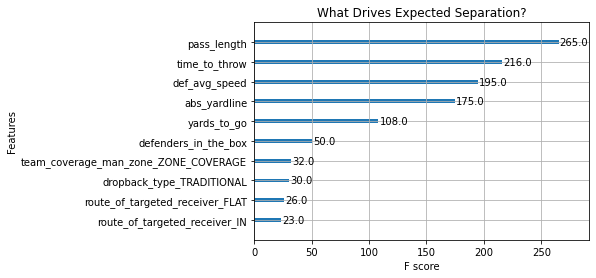

In [59]:
#Which features matter?
xgb.plot_importance(xgbModel, max_num_features=10, title="What Drives Expected Separation?")

In [60]:
#The goal is to determine what the minimum plays needs to be.

#Count plays per play
play_counts = advanced_wr_data.groupby('player_name')['play_id'].count().reset_index()
play_counts = play_counts.rename(columns={'play_id': 'total_plays'})

play_fig = px.histogram(play_counts,
                   x='total_plays',
                   nbins=30,
                   title='Distribution of Player Workloads',
                   labels={'total_plays': 'Number of Targets/Plays'},
                  )

#Current cutoff was around 50, try to figure out where the plays level off
play_fig.add_vline(x=50, line_dash="dash", line_color="black", annotation_text="Current Cutoff (50)")

play_fig.show()

In [61]:
#Build the leaderboard
elite_leaderboard = advanced_wr_data.groupby(['player_name']).agg({
    'wos_advanced': 'mean',
    'sep_at_arrival': 'mean',
    'exp_sep_xgb': 'mean',
    'play_id': 'count'
}).reset_index()

elite_leaderboard = elite_leaderboard[elite_leaderboard['play_id'] >= 65 ] #65 was determined as the graph above demonstrates a power law
elite_leaderboard = elite_leaderboard.sort_values('wos_advanced', ascending=False)

elite_leaderboard = elite_leaderboard.rename(columns={'wos_advanced': 'Advanced_WOS'})
elite_leaderboard.head(15)

,player_name,Advanced_WOS,sep_at_arrival,exp_sep_xgb,play_id
160,Rashee Rice,0.831547,3.934392,3.102845,70
99,Jerry Jeudy,0.550615,3.702769,3.152154,66
31,Chris Olave,0.513395,3.446495,2.933100,122
68,Elijah Moore,0.486004,3.654054,3.168050,83
195,Tyler Lockett,0.409813,3.287599,2.877786,97
97,Jayden Reed,0.390753,3.569632,3.178879,69
37,Cooper Kupp,0.379912,3.229644,2.849732,79
15,Brandon Aiyuk,0.375410,3.331078,2.955668,99
205,Zay Flowers,0.344774,3.590095,3.245321,75
45,Darius Slayton,0.329070,3.276385,2.947315,67


In [62]:
#Visualize the leaderboard on a scatter plot
final_chart_data = elite_leaderboard.copy()

final_figure = px.scatter(final_chart_data, x = 'Advanced_WOS', y = 'exp_sep_xgb', size = 'play_id', color = 'Advanced_WOS', hover_name = 'player_name',
                         text = 'player_name', title = '2023 Wide Receiver Separation (Expected vs. Created)', labels = {'Advanced_WOS': 'WR-Only Separation', 'exp_sep_xgb': 'Expected Separation', 'play_id':'Targets (Counts)'}, color_continuous_scale='Viridis')

#Add lines
final_figure.add_vline(x=0, line_dash="dash", line_color="gray", annotation_text="Creates Sep")
median_difficulty = final_chart_data['exp_sep_xgb'].median()
final_figure.add_hline(y=median_difficulty, line_dash="dash", line_color="gray", annotation_text="Avg. Expected Sep")

final_figure.update_traces(textposition='top center')
final_figure.update_layout(height=700)

final_figure.show()